Dataset size: 5000


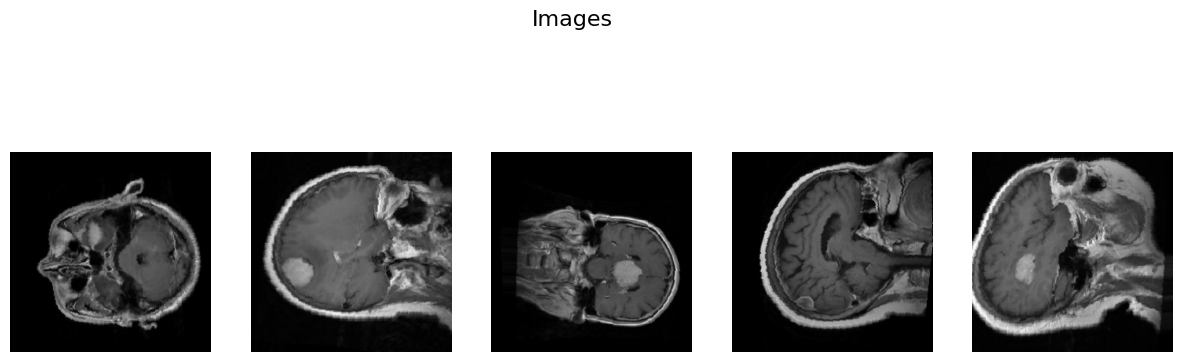

Batch shape: torch.Size([8, 3, 256, 256])


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import time
from GANdefine import ImageDataset, Generator, Discriminator

# Hyperparameters
IMAGE_SIZE = 256
EPOCHS = 1000
NOISE_SIZE = 100
BATCH_SIZE = 8  # Paper 128
LR_D = 0.0002  # Paper 0.0002
LR_G = 0.0004  # Paper 0.0002
BETA1 = 0.9  # Default 0.9
LEAK_RELU_ALPHA = 0.2  # Paper
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_folder = "/home/user/research/lawrence/finalProject/brain_menin"

# Data transformations
data_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)  # Normalize to [-1, 1]
])

# Load dataset
dataset = ImageDataset(data_folder, transform=data_transform)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)
images = next(iter(dataloader))
    
def show_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    fig.suptitle(title, fontsize=16)
    for i, img in enumerate(images):
        img = img.permute(1, 2, 0).numpy()  # 转换为 H, W, C
        img = (img * 0.5 + 0.5) * 255  # 将 [-1, 1] 的归一化值反向转换为 0-255
        axes[i].imshow(img.astype(np.uint8))
        axes[i].axis("off")
    plt.show()

# Show images
print(f"Dataset size: {len(dataset)}")
show_images(images, "Images")

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
for images in dataloader:
    print(f"Batch shape: {images.shape}")
    break

In [2]:
# Training GAN

# Function to visualize noise
def visualize_noise(noise):

    noise = noise.cpu().numpy()
    plt.figure(figsize=(10, 5))
    for i in range(min(len(noise), 10)):  
        plt.subplot(1, 10, i + 1)
        plt.imshow(noise[i].reshape(10, 10), cmap='gray')  
        plt.axis("off")
    plt.suptitle("Visualization of Noise Vectors")
    plt.show()
    
# Visualize generated images
def show_generated_images(images, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, img in enumerate(images[:num_images]):
        img = img.permute(1, 2, 0).numpy()  # Convert to H, W, C
        img = (img * 255).astype(np.uint8)  # Scale to [0, 255]
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.show()

generator_path = "generator.pth"
discriminator_path = "discriminator.pth"

generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

optimizer_g = optim.Adam(generator.parameters(), lr=LR_G, betas=(BETA1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=LR_D, betas=(BETA1, 0.999))

loss_function = nn.BCEWithLogitsLoss()

for epoch in range(EPOCHS):
    start_time = time.time()
    for real_images in dataloader:
        real_images = real_images.to(DEVICE)
        batch_size = real_images.size(0)

        # Train Discriminator
        noise = torch.randn(batch_size, NOISE_SIZE, device=DEVICE)
        # if epoch == 0:
        #     visualize_noise(noise)
            
        fake_images = generator(noise)

        real_labels = torch.ones(batch_size, 1, device=DEVICE)
        fake_labels = torch.zeros(batch_size, 1, device=DEVICE)

        optimizer_d.zero_grad()
        real_loss = loss_function(discriminator(real_images), real_labels)
        fake_loss = loss_function(discriminator(fake_images.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        g_loss = loss_function(discriminator(fake_images), real_labels)
        g_loss.backward()
        optimizer_g.step()

    # 計算 epoch 時間
    epoch_time = time.time() - start_time
    
    print(f"Epoch [{epoch + 1}/{EPOCHS}]  D Loss: {d_loss.item():.4f}  G Loss: {g_loss.item():.4f}  Time: {epoch_time:.2f} seconds")
    
    # Visualize fake images
    # with torch.no_grad():
    #     noise = torch.randn(10, NOISE_SIZE, device=DEVICE)
    #     generated_images = generator(noise).cpu()
    #     generated_images = (generated_images + 1) / 2  # Rescale to [0, 1]
    
    #     show_generated_images(generated_images)
    
    # 儲存生成器 model和鑑別器 model
    torch.save(generator.state_dict(), generator_path)
    torch.save(discriminator.state_dict(), discriminator_path)

Epoch [1/1000]  D Loss: 0.0000  G Loss: 30.6212  Time: 21.47 seconds
Epoch [2/1000]  D Loss: 0.0000  G Loss: 23.6486  Time: 21.21 seconds
Epoch [3/1000]  D Loss: 0.0000  G Loss: 101.4877  Time: 21.23 seconds
Epoch [4/1000]  D Loss: 3.2145  G Loss: 3.9469  Time: 21.19 seconds
Epoch [5/1000]  D Loss: 1.5490  G Loss: 11.4342  Time: 21.19 seconds
Epoch [6/1000]  D Loss: 1.3424  G Loss: 7.5515  Time: 21.20 seconds
Epoch [7/1000]  D Loss: 1.6052  G Loss: 3.1515  Time: 21.20 seconds
Epoch [8/1000]  D Loss: 0.2685  G Loss: 6.7596  Time: 21.19 seconds
Epoch [9/1000]  D Loss: 2.6428  G Loss: 7.1427  Time: 21.20 seconds
Epoch [10/1000]  D Loss: 3.7427  G Loss: 4.9736  Time: 21.20 seconds
Epoch [11/1000]  D Loss: 0.6024  G Loss: 6.9931  Time: 21.20 seconds
Epoch [12/1000]  D Loss: 0.6520  G Loss: 3.0126  Time: 21.19 seconds
Epoch [13/1000]  D Loss: 2.9885  G Loss: 6.3965  Time: 21.19 seconds
Epoch [14/1000]  D Loss: 1.7489  G Loss: 5.5185  Time: 21.20 seconds
Epoch [15/1000]  D Loss: 1.2082  G Los

/tmp/ipykernel_1728710/1385981402.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_path))


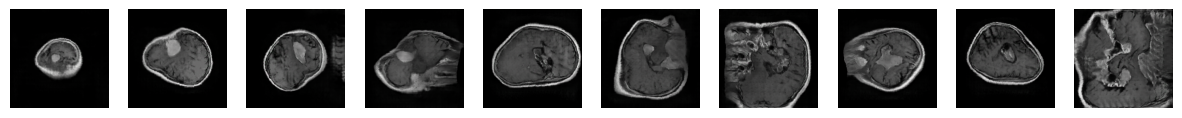

In [3]:
# Generate and save images
generator = Generator().to(DEVICE)
generator.load_state_dict(torch.load(generator_path))
generator.eval()
num_images = 10
with torch.no_grad():
    noise = torch.randn(num_images, NOISE_SIZE, device=DEVICE)
    generated_images = generator(noise).cpu()
    generated_images = (generated_images + 1) / 2  # Rescale to [0, 1]

    show_generated_images(generated_images)

    # Save generated images to disk
    save_folder = "/home/user/research/lawrence/finalProject/GAN_Brain_Menin"
    os.makedirs(save_folder, exist_ok=True)
    for i in range(num_images):
        save_image(generated_images[i], os.path.join(save_folder, f"GAN_image_{i + 1}.png"))